In [13]:
from essentia import *
from essentia.standard import *
import pandas
import os
import numpy as np
import pickle as pkl

path_to_audio = "/Users/simonzimmermann/dev/random_forest_regressor/datasets/vaillant_1/audio/"

list_of_files = os.listdir(path_to_audio)
num_files = list_of_files.__len__()

print('preparing extractor...')
extractor = FreesoundExtractor(profile='custom_extractor_profile.yaml')
features = extractor(path_to_audio + list_of_files[0])
features = features[0]
output = pandas.DataFrame(index=range(num_files), columns=[features.descriptorNames()], dtype='float')
all_features = features.descriptorNames()

print('extracting features...')
for file in range(num_files):
    path = path_to_audio + list_of_files[file]
    features = extractor(path)
    features = features[0]

    for feat in range(len(all_features)):
        current_feat = str(all_features[feat])
        if isinstance(features[current_feat], float):
            output.iloc[file, feat] = features[str(all_features[feat])]
        else:
            break
    begin_list = feat + 1
    for feat in range(begin_list, len(all_features)):
        current_feature = features[str(all_features[feat])]
        if (type(current_feature) != str) or (not current_feature_mean):
            current_feature_list = current_feature.tolist()
            current_feature_mean = np.mean(current_feature_list)
            if np.isnan(current_feature_mean):
                output.iloc[file, feat] = 0.0
            else:
                output.iloc[file, feat] = current_feature_mean
        else: break
    end_list = feat
    print('extracting file ' + str(file) + ' of ' + str(num_files))

output.dropna(axis=1, inplace = True)
output.to_pickle('test_files_features.pkl')
print(output)

preparing extractor...
extracting features...
extracting file 0 of 34
extracting file 1 of 34
extracting file 2 of 34
extracting file 3 of 34
extracting file 4 of 34
extracting file 5 of 34
extracting file 6 of 34
extracting file 7 of 34
extracting file 8 of 34
extracting file 9 of 34
extracting file 10 of 34
extracting file 11 of 34
extracting file 12 of 34
extracting file 13 of 34
extracting file 14 of 34
extracting file 15 of 34
extracting file 16 of 34
extracting file 17 of 34
extracting file 18 of 34
extracting file 19 of 34
extracting file 20 of 34
extracting file 21 of 34
extracting file 22 of 34
extracting file 23 of 34
extracting file 24 of 34
extracting file 25 of 34
extracting file 26 of 34
extracting file 27 of 34
extracting file 28 of 34
extracting file 29 of 34
extracting file 30 of 34
extracting file 31 of 34
extracting file 32 of 34
extracting file 33 of 34
   lowlevel.average_loudness lowlevel.barkbands_crest.dmean  \
0                   0.039892                       

loading data...
training model...
plotting feature importance...
evaluating n_estimators...


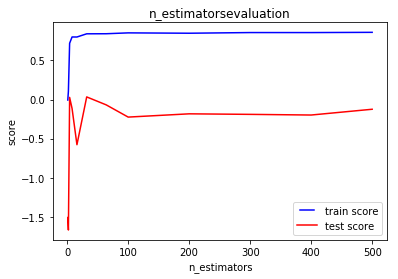

<Figure size 432x288 with 0 Axes>

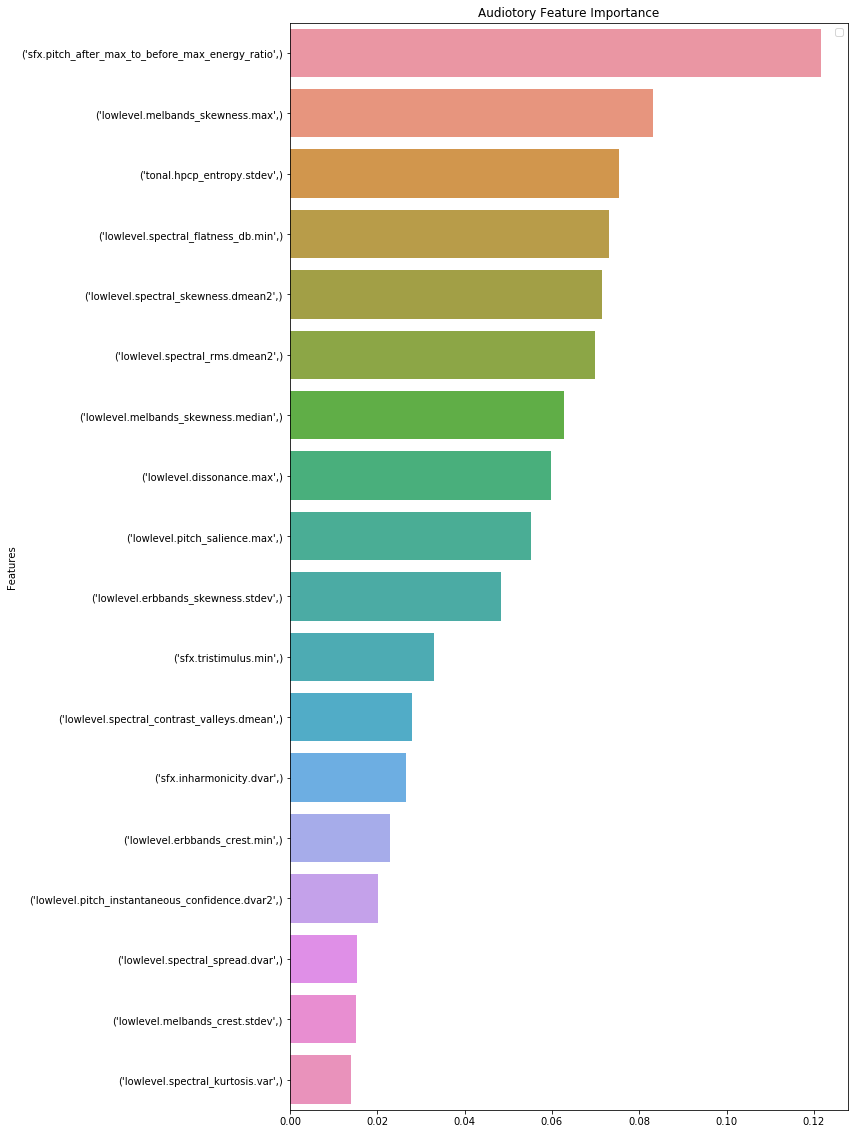

evaluating max_depth...


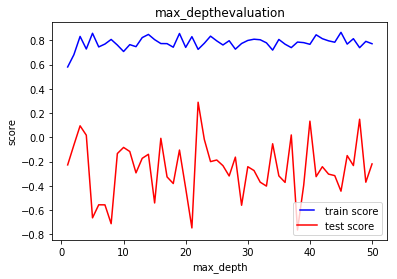

evaluating min_samples_split...


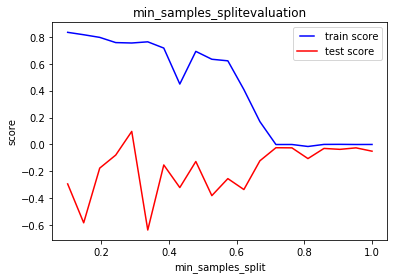

evaluating min_samples_leaf...


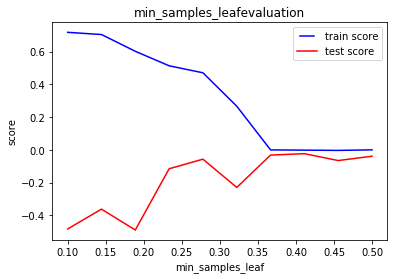

evaluating max_features...


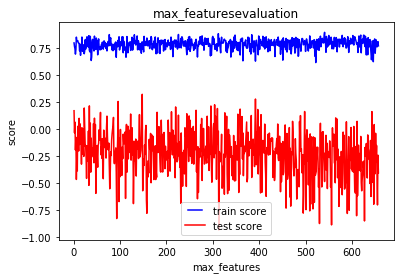

In [9]:
import pickle as pkl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

def evaluation(feature, feat_values):
    plt.figure(0)
    print('evaluating '+feature+'...')
    train_results = []
    test_results = []
    for feat in feat_values:
        if feature == 'n_estimators':
            regressor = RandomForestRegressor(n_estimators=feat,
                                              criterion='mse')
        if feature == 'max_depth':
            regressor = RandomForestRegressor(max_depth=feat,
                                              criterion='mse')
        if feature == 'min_samples_split':
            regressor = RandomForestRegressor(min_samples_split=feat,
                                              criterion='mse')
        if feature == 'min_samples_leaf':
            regressor = RandomForestRegressor(min_samples_leaf=feat,
                                              criterion='mse')
            
        if feature == 'max_features':
            regressor = RandomForestRegressor(max_features=feat,
                                              criterion='mse')

        regressor.fit(x_train, y_train)
        train_pred = regressor.predict(x_train)
        y_pred = regressor.predict(x_test)

        test_score = regressor.score(x_test, y_test)
        train_score = regressor.score(x_train, y_train)

        train_results.append(train_score)
        test_results.append(test_score)

    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(feat_values, train_results, 'b', label="train score")
    line2, = plt.plot(feat_values, test_results, 'r', label="test score")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.title(feature+'evaluation')
    plt.ylabel('score')
    plt.xlabel(feature)
    plt.show()
    
def plot_feature_imp(regressor_model):
    print('plotting feature importance...')
    feature_imp = pd.Series(regressor_model.feature_importances_, index=x_input.columns).sort_values(ascending=False)
    feature_imp = feature_imp[feature_imp > 0.01]  
    a4_dims = (10, 20)
    plt.figure(1)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.barplot(ax=ax, x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance Score")
    plt.ylabel('Features')
    plt.title("Audiotory Feature Importance")
    plt.legend()
    
    
print('loading data...')
data = pkl.load(open("/Users/simonzimmermann/dev/random_forest_regressor/test_files_features.pkl", "rb"))
num_features = len(data.iloc[0]) - 1
x_input = data.iloc[:, : num_features]
x_input = x_input.fillna(0)
target = pkl.load(open("/Users/simonzimmermann/dev/random_forest_regressor/datasets/vaillant_1/pkl/vaillant_1.pkl"))

print('training model...')
x_train, x_test, y_train, y_test = train_test_split(x_input, target, test_size=0.3)

regressor = RandomForestRegressor(criterion='mse')
regressor.fit(x_train, y_train)
plot_feature_imp(regressor)

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 400, 500]
evaluation('n_estimators', n_estimators)
max_depths = np.linspace(1,50,50)
evaluation('max_depth', max_depths)
min_samples_splits = np.linspace(0.1,1,20)
evaluation('min_samples_split', min_samples_splits)
min_samples_leafs = np.linspace(0.1,0.5,10)
evaluation('min_samples_leaf', min_samples_leafs)
max_features = list(range(1,num_features))
evaluation('max_features', max_features)
